In [44]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.decomposition import PCA,IncrementalPCA,KernelPCA
from sklearn import datasets
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import mean_squared_error
from sklearn.manifold import LocallyLinearEmbedding

# **DIMENSIONALTY** **REDUCTION**

## **1.PCA**

#### **Principal** **Components** **using**  **SVD**

In [2]:
                                            #using numpy's svd()
np.random.seed(4) #make the generation of random numbers deterministic
m = 60
w1, w2 = 0.1, 0.3
noise = 0.1

angles = np.random.rand(m) * 3 * np.pi / 2 - 0.5
X = np.empty((m, 3))                #generate 60*3 array
X[:, 0] = np.cos(angles) + np.sin(angles)/2 + noise * np.random.randn(m) / 2
X[:, 1] = np.sin(angles) * 0.7 + noise * np.random.randn(m) / 2
X[:, 2] = X[:, 0] * w1 + X[:, 1] * w2 + noise * np.random.randn(m)

In [3]:
#center the dataset around the origin
X_centered=X-X.mean(axis=0)

In [4]:
U,s,Vt=np.linalg.svd(X_centered)
print(Vt)
print(Vt.T)

[[ 0.93636116  0.29854881  0.18465208]
 [-0.34027485  0.90119108  0.2684542 ]
 [-0.08626012 -0.31420255  0.94542898]]
[[ 0.93636116 -0.34027485 -0.08626012]
 [ 0.29854881  0.90119108 -0.31420255]
 [ 0.18465208  0.2684542   0.94542898]]


In [5]:
c1=Vt.T[:,0]   #pc1
c2=Vt.T[:,1]   #pc2

In [6]:
w2=Vt.T[:,:2]   #matrix containing the first 2 colums of V (first two PCs)
print(w2)

[[ 0.93636116 -0.34027485]
 [ 0.29854881  0.90119108]
 [ 0.18465208  0.2684542 ]]


In [7]:
X2D=X_centered.dot(w2) #this is the matrix with reduced dimensions from 3D to 2D

#### **Using** **Scikit** **Learn**

In [8]:
pca=PCA(n_components=2)
X2D=pca.fit_transform(X)

In [9]:
pca.components_        #it gives the transpose of w2

array([[-0.93636116, -0.29854881, -0.18465208],
       [ 0.34027485, -0.90119108, -0.2684542 ]])

In [10]:
pca.components_.T[:,0] #gives the first pc

array([-0.93636116, -0.29854881, -0.18465208])

In [11]:
pca.explained_variance_ratio_  #gives the proportion of the dataset's variance that lies along each principal component

array([0.84248607, 0.14631839])

### Choosing the right number of dimensions

In [12]:
 mnist=datasets.fetch_openml('mnist_784')
 print(mnist.keys())

dict_keys(['data', 'target', 'frame', 'feature_names', 'target_names', 'DESCR', 'details', 'categories', 'url'])


In [13]:
X=mnist['data']
y=mnist['target']

In [14]:
                       #1st way
X_train,X_test,y_train,y_test=train_test_split(X,y,random_state=42)
#perform the PCA without reducing dimensionality
pca=PCA()
pca.fit(X_train)
cumsum=np.cumsum(pca.explained_variance_ratio_ )
d=np.argmax(cumsum>0.95)+1

#perform again PCA with n_estimators=d

pca=PCA(n_components=d)
X_train_reduced=pca.fit_transform(X_train)

In [15]:
                            #2nd way
pca=PCA(n_components=0.95)
X_train_reduced=pca.fit_transform(X_train)
print(X_train.shape)
print(X_train_reduced.shape)

(52500, 784)
(52500, 154)


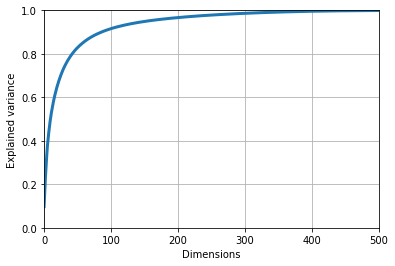

In [16]:
                                #3rd way (plot the explained variance)
plt.plot(cumsum,linewidth=3)
plt.axis([0,500,0,1])
plt.xlabel('Dimensions')
plt.ylabel('Explained variance')
plt.grid()
plt.show()
#from the plot we get dimensions around 154 as before

### **PCA** **for** **Compression** **(Compression and decompression)**

In [17]:
X_train_recovered=pca.inverse_transform(X_train_reduced)

In [18]:
print(X_train_recovered.shape)

(52500, 784)


### **Randomized** **PCA**

In [19]:
rnd_pca=PCA(n_components=154,svd_solver="randomized")
X_reduced=rnd_pca.fit_transform(X_train)

In [20]:
print(X_reduced.shape)

(52500, 154)


### **Incremental** **PCA**

In [21]:
                                #1st way
n_batches=100
inc_pca=IncrementalPCA(n_components=154)

for X_bactch in np.array_split(X_train,n_batches):
  inc_pca.partial_fit(X_bactch)

X_reduced=inc_pca.transform(X_train)
print(X_reduced.shape)

(52500, 154)


In [22]:
                              #2nd way (by using np.memmap())
m,n=X_train.shape
# X_mm=np.memmap('mnist.data',dtype='float32',mode='readonly',shape=(m,n))

# batch_size=m//n_batches
# inc_pca=IncrementalPCA(n_components=154,batch_size=batch_size)
# inc.fit(X_mm)

## **Kernel** **PCA**

In [37]:
#load swiss roll data
X,t=datasets.make_swiss_roll(n_samples=100,noise=0.2,random_state=42)
print(X.shape)

(100, 3)


In [27]:
rbf_pca=KernelPCA(n_components=2,kernel='rbf',gamma=0.04)
X_reduced=rbf_pca.fit_transform(X)

In [28]:
print(X_reduced.shape)

(100, 2)


#### * **Selecting** **a** **kernel** **and** **hyperparameters**

##### 1. That yield best classification accuracy

In [40]:
y=t>6.9

clf=Pipeline([
              ("kpca",KernelPCA(n_components=2)),
              ("log_reg",LogisticRegression())
])

param_grid=[{
    'kpca__gamma':np.linspace(0.03,0.05,10),
    'kpca__kernel':['rbf','sigmoid']            #the keys name should be as they are
}]

grid_search=GridSearchCV(clf,param_grid,cv=3)
grid_search.fit(X,y)

print(grid_search.best_params_)

{'kpca__gamma': 0.03, 'kpca__kernel': 'rbf'}


#### 2.That yield the lowest reconstruction error

In [41]:
#reduce dimension using kernel rbf
rbf_pca=KernelPCA(n_components=2,kernel='rbf',gamma=0.03,fit_inverse_transform=True)
X_reduced=rbf_pca.fit_transform(X)

#do reconstruction
X_preimage=rbf_pca.inverse_transform(X_reduced)


In [43]:
mean_squared_error(X,X_preimage)

34.47705154687314

## **LLE**

In [45]:
lle=LocallyLinearEmbedding(n_neighbors=10,n_components=2)
X_reduced=lle.fit_transform(X)

In [47]:
print(X_reduced.shape)

(100, 2)
